In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from wm import Image as PolarImage
from PIL import Image

In [3]:
from wm.moments import RadialHarmonicFourierMoment
from wm.moments import ZernikeMoment, PseudoZernikeMoment

## Embedding

In [4]:
L = 32
# data
np.random.seed(0)
data = np.random.randint(2, size=L)
pos = list(range(len(data)))

In [5]:
data

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0])

In [6]:
W = 64
order = 16
qs = 0.5
# method
mname = 'ZM'
method = ZernikeMoment(order+1, W, qs=qs)
# image
pim = PolarImage('lena_'+str(W)+'.png')
pime = method.encode(pim.grey, data, verbose=True)
im = Image.fromarray(pime.im)

In [7]:
im.save(''.join(['lena_',str(W),'_'+mname+'_','N',str(order),'L',str(L),'.png']))

In [8]:
imdiff = np.abs(pim.grey.im.astype('float16') - pime.im.astype('float16')).astype('uint8')
II = PolarImage(10*imdiff, colored=False)

In [9]:
Image.fromarray(II.im).save(''.join(['lena_',str(W),'_'+mname+'_diff_','N',str(order),'L',str(L),'.png']))

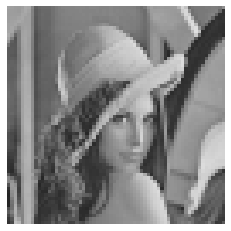

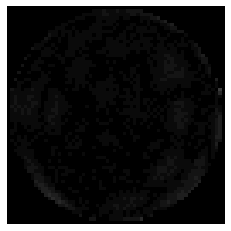

In [10]:
pime.show()
II.show()

## Benchmarks

In [11]:
from wm.benchmarks.geometry import Resize, Rotate, Flip

In [12]:
# RESIZE
scales = [0.2, 0.25, 0.333, 0.5, 0.666, 0.75, 0.8, 1.1, 1.5, 2, 3]
bs_resize_nearest = [ Resize(method, data, pos=pos, scale=s, resample=Image.NEAREST, name='RHFM/Resize/Nearest/'+str(s)) for s in scales ]
bs_resize_linear  = [ Resize(method, data, pos=pos, scale=s, resample=Image.LINEAR,  name='RHFM/Resize/Linear/'+str(s))  for s in scales ]
bs_resize_bicubic = [ Resize(method, data, pos=pos, scale=s, resample=Image.BICUBIC, name='RHFM/Resize/Bicubic/'+str(s)) for s in scales ]
bs_resize_lanczos = [ Resize(method, data, pos=pos, scale=s, resample=Image.LANCZOS, name='RHFM/Resize/Lanczos/'+str(s)) for s in scales ]
# ROTATE
angles = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 90, 180, 270]
bs_rotate_nearest = [ Rotate(method, data, pos=pos, angle=a, resample=Image.NEAREST, name='RHFM/Rotate/Nearest/'+str(a)) for a in angles ]
bs_rotate_linear  = [ Rotate(method, data, pos=pos, angle=a, resample=Image.LINEAR,  name='RHFM/Rotate/Linear/'+str(a))  for a in angles ]
bs_rotate_bicubic = [ Rotate(method, data, pos=pos, angle=a, resample=Image.BICUBIC, name='RHFM/Rotate/Bicubic/'+str(a)) for a in angles ]
# FLIP
flips = [Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM]
bs_flip = [ Flip(method, data, pos=pos, direction=d, name='RHFM/Flip/'+str('UD' if d else 'LR')) for d in flips ]

In [13]:
from wm.benchmarks.filter import Blur, Sharpen, SaltPapperNoise

In [14]:
# GAUSSBLUR
blurs = [1, 2, 3, 4, 5]
bs_blur = [ Blur(method, data, pos=pos, radius=r, name='RHFM/Blur/'+str(r)) for r in blurs ]
# SHARPEN
sharpens = [5, 10, 20, 30, 40, 50, 100]
bs_sharpen = [ Sharpen(method, data, pos=pos, radius=3, percent=s, name='RHFM/Sharpen/'+str(s)) for s in sharpens ]
# GAUSSBLUR
sps = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
bs_saltpepper = [ SaltPapperNoise(method, data, pos=pos, amount=a, name='RHFM/SaltPepper/'+str(a)) for a in sps ]

In [15]:
from wm.benchmarks.compression import JPEG, JPEG2000

In [16]:
# JPEG
qualities = [100, 95, 90, 85, 80, 75, 70, 65, 60, 50, 10, 5]
bs_jpeg = [ JPEG(method, data, pos=pos, quality=q, name='RHFM/JPEG/'+str(q)) for q in qualities ]
bs_jpeg2000 = [ JPEG2000(method, data, pos=pos, name='RHFM/JPEG2000') ]

### Run

In [17]:
from functools import reduce
from wm.benchmarks.Benchmark import Benchmark

In [18]:
bs_ = reduce(lambda a,b: a+b, [
    # RESIZE
    bs_resize_nearest,
    bs_resize_linear,
    bs_resize_bicubic,
    bs_resize_lanczos,
    # ROTATE
    bs_rotate_nearest,
    bs_rotate_linear,
    bs_rotate_bicubic,
    # FLIP
    bs_flip,
    # NOISE
    bs_blur,
    bs_sharpen,
    bs_saltpepper,
    # COMPRESSION
    bs_jpeg,
    bs_jpeg2000,
], [])

In [19]:
print(Benchmark(method, data, pos=pos)(im))
for b in bs_:
    res = b(im)
    print(''.join([b.name, '\t', str(res)]))

1.0
RHFM/Resize/Nearest/0.2	0.40625
RHFM/Resize/Nearest/0.25	0.71875
RHFM/Resize/Nearest/0.333	0.53125
RHFM/Resize/Nearest/0.5	0.375
RHFM/Resize/Nearest/0.666	0.5625
RHFM/Resize/Nearest/0.75	0.53125
RHFM/Resize/Nearest/0.8	0.625
RHFM/Resize/Nearest/1.1	0.375
RHFM/Resize/Nearest/1.5	0.5
RHFM/Resize/Nearest/2	0.5625
RHFM/Resize/Nearest/3	0.53125
RHFM/Resize/Linear/0.2	0.40625
RHFM/Resize/Linear/0.25	0.71875
RHFM/Resize/Linear/0.333	0.53125
RHFM/Resize/Linear/0.5	0.375
RHFM/Resize/Linear/0.666	0.5625
RHFM/Resize/Linear/0.75	0.53125
RHFM/Resize/Linear/0.8	0.625
RHFM/Resize/Linear/1.1	0.375
RHFM/Resize/Linear/1.5	0.5
RHFM/Resize/Linear/2	0.5625
RHFM/Resize/Linear/3	0.53125
RHFM/Resize/Bicubic/0.2	0.40625
RHFM/Resize/Bicubic/0.25	0.71875
RHFM/Resize/Bicubic/0.333	0.53125
RHFM/Resize/Bicubic/0.5	0.375
RHFM/Resize/Bicubic/0.666	0.5625
RHFM/Resize/Bicubic/0.75	0.53125
RHFM/Resize/Bicubic/0.8	0.625
RHFM/Resize/Bicubic/1.1	0.375
RHFM/Resize/Bicubic/1.5	0.5
RHFM/Resize/Bicubic/2	0.5625
RHFM/Resize